In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

import os
import sys
sys.path.append('../code/')
import preprocess

from sklearn.decomposition import PCA
from umap import UMAP
from scipy.stats import pearsonr

import scanpy as sc

/Users/benceszalai/opt/anaconda3/envs/scanpy/lib/python3.7/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


In [2]:
import pandas as pd
import numpy as np

import sys
sys.path.append('../code/')
import preprocess
import qc

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from scipy.stats import spearmanr

In [219]:
data = pd.read_csv('../results/lukas-bulk/seqRT//count-matrix.csv',
                  sep=',', header=0, index_col=0).T
meta = pd.read_csv('../results/lukas-bulk/seqRT//meta.csv',
                  sep=',', header=0, index_col=0)

In [220]:
mapping = pd.Series(index=['Trametinib', 'Imatinib', 'YM115', 'DMSO'],
                   data=['Trametinib', 'Imatinib', 'YM155', 'DMSO'])
meta['Drug1'] = meta['Drug1'].map(mapping)
meta['Drug2'] = meta['Drug2'].map(mapping)

In [221]:
adata = sc.AnnData(X=data, obs=meta)
sc.pp.normalize_total(adata, target_sum=1e4, exclude_highly_expressed=True)
sc.pp.log1p(adata)
sc.pp.combat(adata, 'rep')
sc.pp.scale(adata)
adata.to_df().to_csv('../results/lukas-bulk/seqRT//scanpy.csv')

... storing 'Drug1' as categorical
... storing 'Drug2' as categorical
... storing 'Comb' as categorical
... storing 'CombOrdered' as categorical
... storing 'rep' as categorical
/Users/benceszalai/opt/anaconda3/envs/scanpy/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


In [222]:
new = pd.read_csv('../results/lukas-bulk/seqRT/////scanpy.csv',
                 sep=',', header=0, index_col=0).T
old = pd.read_csv('../results/small_scale/filtered_dt_HGNC_counts_30_sc.csv',
                 sep=',', header=0, index_col=0).T

In [223]:
progeny = pd.read_csv('../data/external/progeny.csv', header=0, index_col=0)
progeny = pd.pivot_table(progeny, index='gene', columns='pathway', values='weight')
progeny[progeny.isna()] = 0.0
progeny['JAK'] = progeny['JAK-STAT']
del progeny['JAK-STAT']

In [224]:
new = preprocess.translate_gene_ids(new.copy())

In [225]:
def calculate_progeny(data, progeny):
    np.random.seed(19890904)
    scores = np.zeros((10001, data.shape[0], progeny.shape[1]), float)
    scores[0,:,:] = np.dot(data, progeny)
    for i in range(1, 10001):
        data.columns = np.random.choice(data.columns, len(data.columns), False)
        data = data[genes]
        scores[i,:,:] = np.dot(data, progeny)
    bg = scores[1:]
    scores = scores[0]
    scores = pd.DataFrame((scores - bg.mean(0)) / bg.std(0), index=data.index, columns=progeny.columns)
    del scores['WNT']
    return scores

In [227]:
#genes = list(set(progeny.index) & set(new.index) & set(old.index))
#new = calculate_progeny(new.T[genes], progeny.loc[genes]).T
#old = calculate_progeny(old.T[genes], progeny.loc[genes]).T

In [228]:
genes = list(set(progeny.index) & set(new.index) & set(old.index))

new = (new.T[genes] @ progeny.loc[genes]).T
old = (old.T[genes] @ progeny.loc[genes]).T

new = new.apply(lambda x: (x-x.mean())/x.std(), axis=1)
old = old.apply(lambda x: (x-x.mean())/x.std(), axis=1)

In [229]:
shared = list(set(new.index) & set(old.index))

In [230]:
old = old.loc[shared]
new = new.loc[shared]

In [231]:
meta_old = pd.read_csv('../results/small_scale/filtered_dt_HGNC_meta_30.csv',
                      sep=',', header=0, index_col=0)
meta_old['Drug1'] = meta_old['Drug1'].map(mapping)
meta_old['Drug2'] = meta_old['Drug2'].map(mapping)
hm_col = sns.color_palette('YlGnBu', 3)
anno_old = pd.DataFrame('w', index=meta_old.index, columns=list(set(meta_old['Drug1']) | set(meta_old['Drug2'])))
for i in meta_old.index:
    d1, d2 = meta_old.loc[i, ['Drug1', 'Drug2']]
    anno_old.loc[i, d1] = hm_col[0]
    anno_old.loc[i, d2] = hm_col[2]
    if d1 == d2:
        anno_old.loc[i, d1] = hm_col[1]

In [232]:
meta_new = pd.read_csv('../results/lukas-bulk/seqRT////meta.csv',
                      sep=',', header=0, index_col=0)
meta_new['Drug1'] = meta_new['Drug1'].map(mapping)
meta_new['Drug2'] = meta_new['Drug2'].map(mapping)
hm_col = sns.color_palette('YlGnBu', 3)
anno_new = pd.DataFrame('w', index=meta_new.index, columns=list(set(meta_new['Drug1']) | set(meta_new['Drug2'])))
for i in meta_new.index:
    d1, d2 = meta_new.loc[i, ['Drug1', 'Drug2']]
    anno_new.loc[i, d1] = hm_col[0]
    anno_new.loc[i, d2] = hm_col[2]
    if d1 == d2:
        anno_new.loc[i, d1] = hm_col[1]

In [233]:
fil = meta_old['Combo']!= 'DMSO_DMSO'
meta_old = meta_old[fil]

fil = meta_new['Comb']!= 'DMSO_DMSO'
meta_new = meta_new[fil]
old = old[meta_old.index]
new = new[meta_new.index]

In [234]:
all_data = pd.concat([new, old], 1)
sim = all_data.corr('spearman')
sim = sim.loc[new.columns, old.columns]

In [235]:
sim.index.name = 'Bulk'
sim.columns.name = 'Droplet'

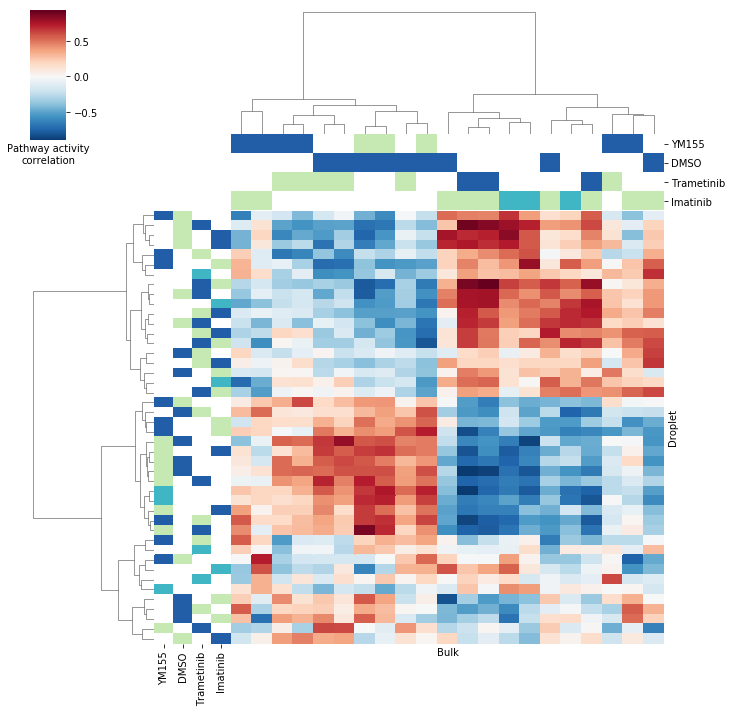

In [253]:
sns.clustermap(sim.T, cmap='RdBu_r', method='ward', yticklabels=False, xticklabels=False,
              row_colors=anno_old, col_colors=anno_new, center=0)
plt.xlabel('Pathway activity\ncorrelation')
plt.savefig('../figures/revision/bulk-droplet-corr-heatmap.pdf')

### recolor tsne

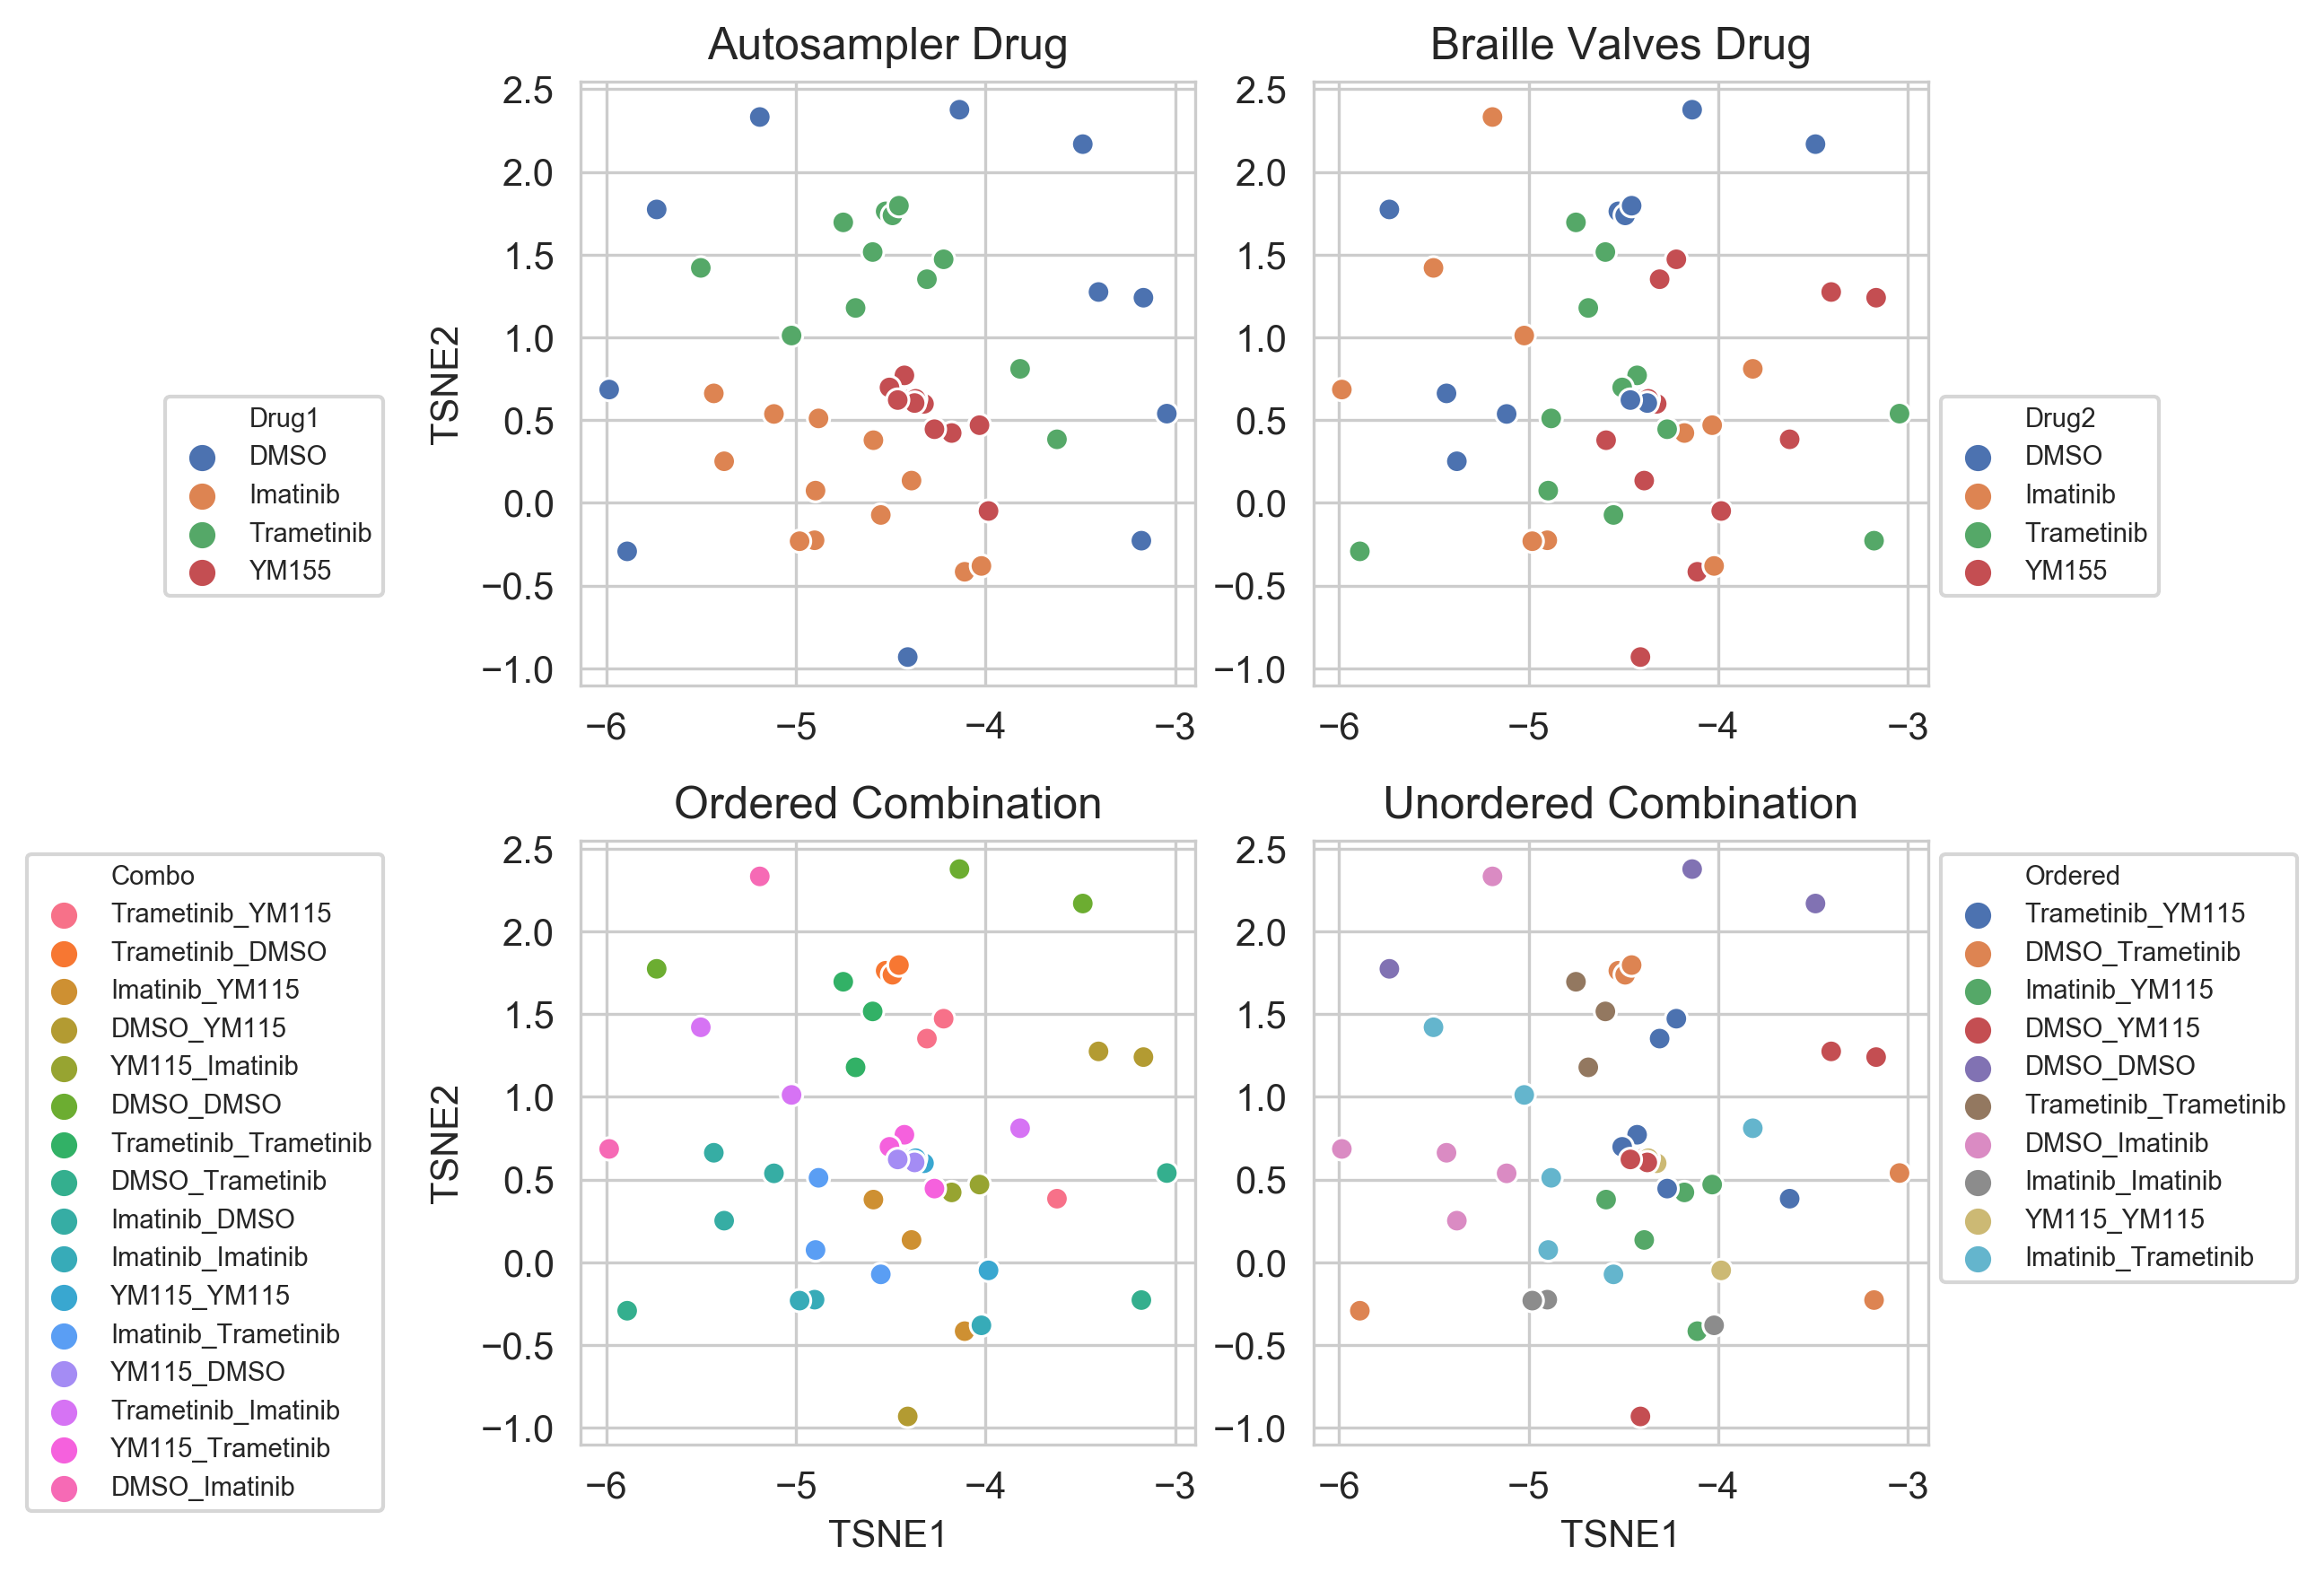

In [289]:
data = pd.read_csv('../results/small_scale/filtered_dt_HGNC_counts_30_sc.csv',
                  sep=',', header=0, index_col=0)
meta = pd.read_csv('../results/small_scale/filtered_dt_HGNC_meta_30.csv', sep=',', header=0, index_col=0)
#remove outlier
data = data.drop('Run_1_dT_DMSO_ImatinibReadsPerGene', 0)
meta = meta.loc[data.index]

fil = meta['Drug1'] == 'YM115'
meta.loc[meta.index[fil], 'Drug1'] = 'YM155'
fil = meta['Drug2'] == 'YM115'
meta.loc[meta.index[fil], 'Drug2'] = 'YM155'

model = PCA()
data_pca = pd.DataFrame(model.fit_transform(data), index=data.index)
np.random.seed(19890904)
model = TSNE(perplexity=30, learning_rate=40)
data_tsne = pd.DataFrame(model.fit_transform(data_pca), index=data.index)

f, axs = plt.subplots(2, 2, figsize=(9, 6), dpi=300)
sns.set_palette('deep')
sns.scatterplot(data_tsne[0], data_tsne[1], hue=meta['Drug1'], ax=axs[0, 0], 
               hue_order=['DMSO', 'Imatinib', 'Trametinib', 'YM155'])
sns.scatterplot(data_tsne[0], data_tsne[1], hue=meta['Drug2'], ax=axs[0, 1],
               hue_order=['DMSO', 'Imatinib', 'Trametinib', 'YM155'])
sns.scatterplot(data_tsne[0], data_tsne[1], hue=meta['Combo'], ax=axs[1, 0])
sns.scatterplot(data_tsne[0], data_tsne[1], hue=meta['Ordered'], ax=axs[1, 1])
axs[0, 0].legend(fontsize=7, bbox_to_anchor=(-0.3, 0.5))
axs[0, 1].legend(fontsize=7, bbox_to_anchor=(1.0, 0.5))
axs[1, 0].legend(fontsize=7, bbox_to_anchor=(-0.3, 1))
axs[1, 1].legend(fontsize=7, bbox_to_anchor=(1.0, 1))
axs[0, 0].set_title('Autosampler Drug')
axs[0, 1].set_title('Braille Valves Drug')
axs[1, 0].set_title('Ordered Combination')
axs[1, 1].set_title('Unordered Combination')
for i in (0, 1):
    for j in (0, 1):
        if i==0:
            axs[i, j].set_xlabel('')
        else:
            axs[i, j].set_xlabel('TSNE1')
        if j==0:
            axs[i, j].set_ylabel('TSNE2')
        else:
            axs[i, j].set_ylabel('')
plt.tight_layout()
plt.savefig('../figures/revision/fig3a.pdf')

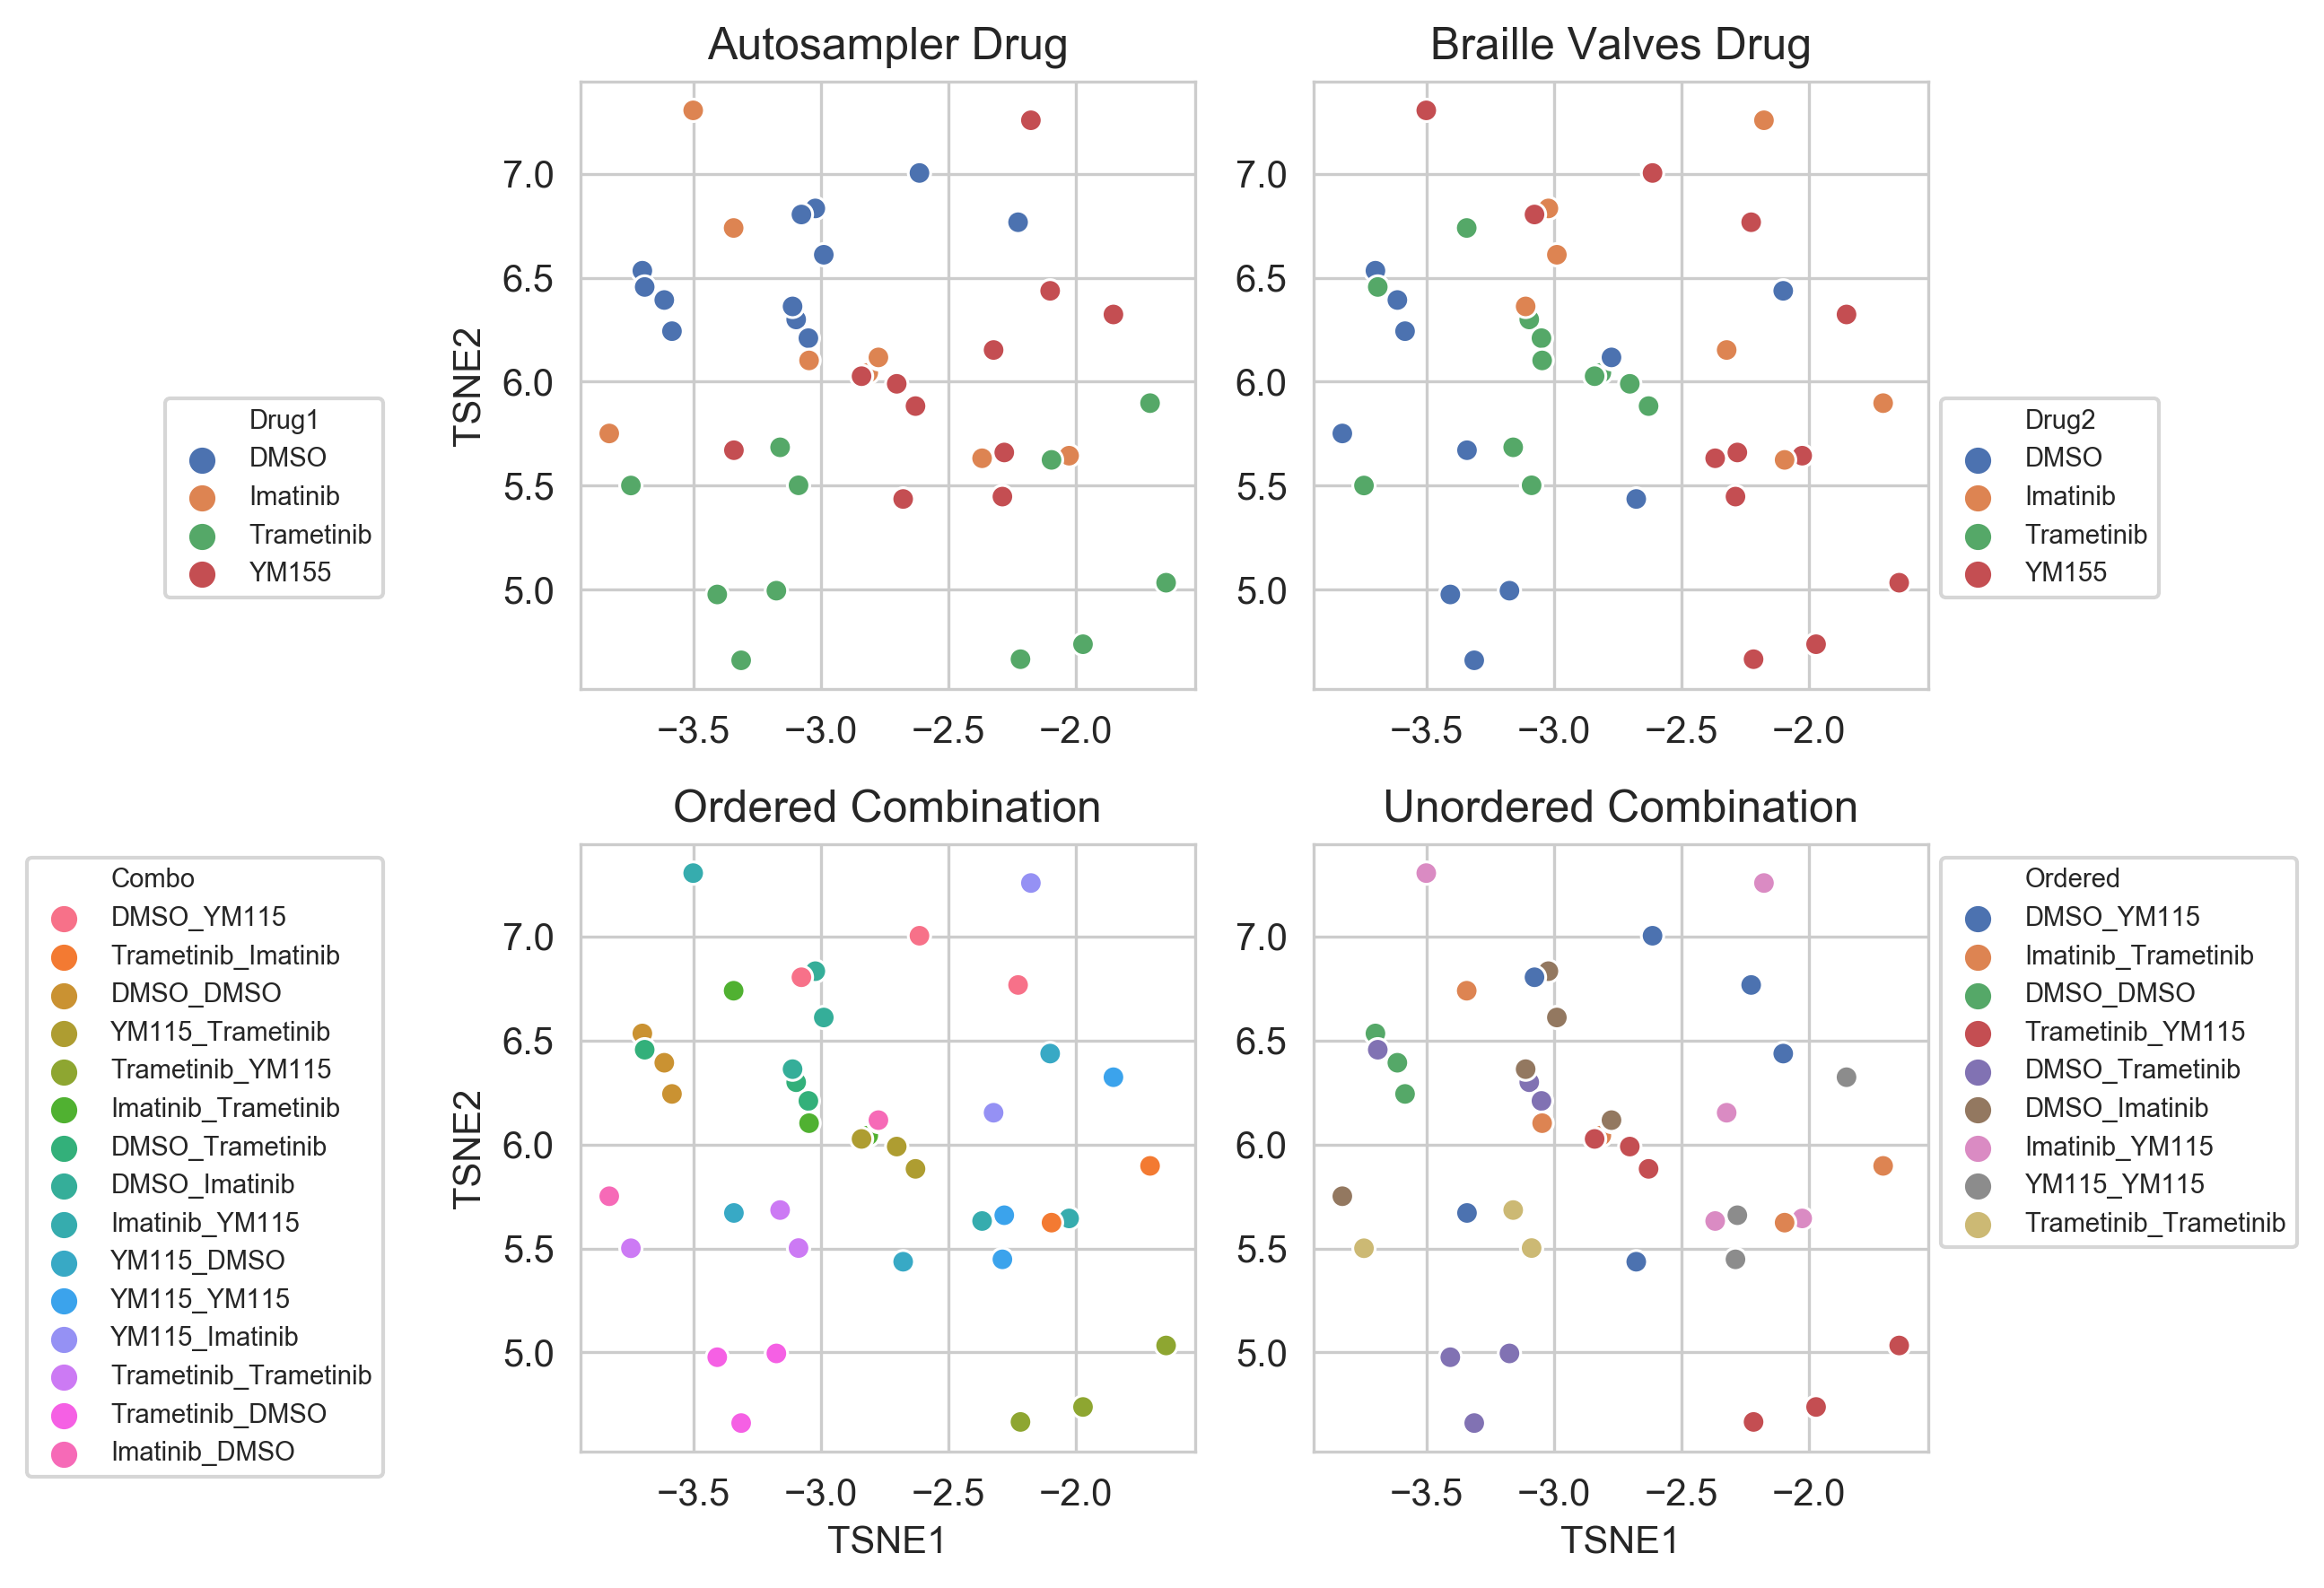

In [293]:
data = pd.read_csv('../results/small_scale/filtered_bio_HGNC_counts_10_sc.csv',
                  sep=',', header=0, index_col=0)
meta = pd.read_csv('../results/small_scale/filtered_bio_HGNC_meta_10.csv', sep=',', header=0, index_col=0)
#remove outlier
data = data.drop('Run_2_Bio_Imatinib_DMSOReadsPerGene', 0)
meta = meta.loc[data.index]
fil = meta['Drug1'] == 'YM115'
meta.loc[meta.index[fil], 'Drug1'] = 'YM155'
fil = meta['Drug2'] == 'YM115'
meta.loc[meta.index[fil], 'Drug2'] = 'YM155'
model = PCA()
data_pca = pd.DataFrame(model.fit_transform(data), index=data.index)
np.random.seed(19890904)
model = TSNE(perplexity=30, learning_rate=40)
data_tsne = pd.DataFrame(model.fit_transform(data_pca), index=data.index)
f, axs = plt.subplots(2, 2, figsize=(9, 6), dpi=300)
sns.set_palette('deep')
sns.scatterplot(data_tsne[0], data_tsne[1], hue=meta['Drug1'], ax=axs[0, 0], 
               hue_order=['DMSO', 'Imatinib', 'Trametinib', 'YM155'])
sns.scatterplot(data_tsne[0], data_tsne[1], hue=meta['Drug2'], ax=axs[0, 1],
               hue_order=['DMSO', 'Imatinib', 'Trametinib', 'YM155'])
sns.scatterplot(data_tsne[0], data_tsne[1], hue=meta['Combo'], ax=axs[1, 0])
sns.scatterplot(data_tsne[0], data_tsne[1], hue=meta['Ordered'], ax=axs[1, 1])
axs[0, 0].legend(fontsize=7, bbox_to_anchor=(-0.3, 0.5))
axs[0, 1].legend(fontsize=7, bbox_to_anchor=(1.0, 0.5))
axs[1, 0].legend(fontsize=7, bbox_to_anchor=(-0.3, 1))
axs[1, 1].legend(fontsize=7, bbox_to_anchor=(1.0, 1))
axs[0, 0].set_title('Autosampler Drug')
axs[0, 1].set_title('Braille Valves Drug')
axs[1, 0].set_title('Ordered Combination')
axs[1, 1].set_title('Unordered Combination')
for i in (0, 1):
    for j in (0, 1):
        if i==0:
            axs[i, j].set_xlabel('')
        else:
            axs[i, j].set_xlabel('TSNE1')
        if j==0:
            axs[i, j].set_ylabel('TSNE2')
        else:
            axs[i, j].set_ylabel('')
plt.tight_layout()
plt.savefig('../figures/revision/sfig8a.pdf')

In [323]:
temp = pd.read_csv('/Users/benceszalai/Documents/Data/ALMANAC/response/almanac_raw.csv',
                  sep=',', header=0, index_col=0)

/Users/benceszalai/opt/anaconda3/envs/scanpy/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/benceszalai/opt/anaconda3/envs/scanpy/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [325]:
fil = temp['SCORE'].isna()
temp = temp[~fil]
temp = temp[['NSC1', 'NSC2', 'CELLNAME', 'SCORE']].groupby(['NSC1', 'NSC2', 'CELLNAME']).mean()['SCORE']

In [333]:
#fil = temp.isna()
#temp = temp[~fil]
fil = temp.abs() < 30
temp = temp[fil]

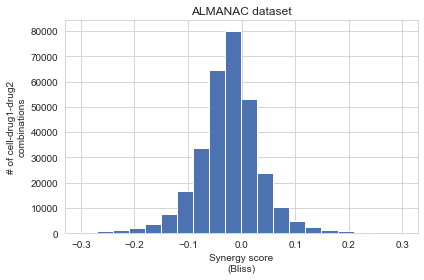

In [337]:
temp = temp/100
temp.hist(bins=20)
plt.xlabel('Synergy score\n(Bliss)')
plt.ylabel('# of cell-drug1-drug2\ncombinations')
plt.title('ALMANAC dataset')
plt.tight_layout()
plt.savefig('../figures/revision/almanac-synergy.pdf')

LINCS similarity

0.5942281312651683


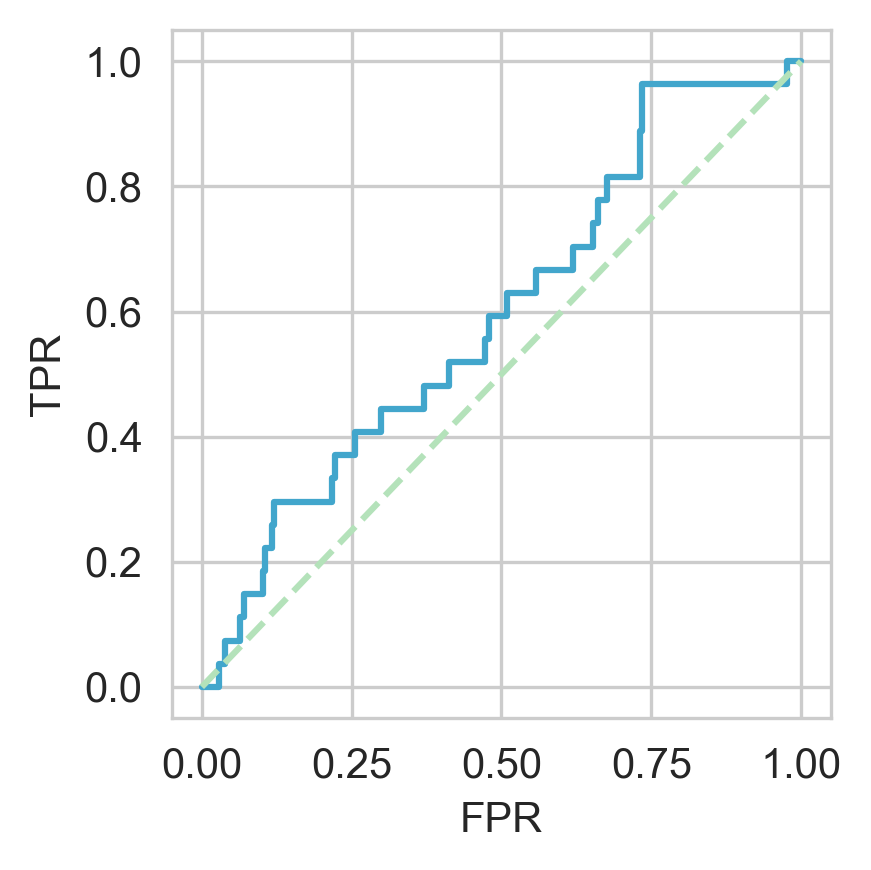

In [3]:
data = pd.read_csv('../results/large_scale/filtered_HGNC_counts_100_sc.csv',
                  sep=',', header=0, index_col=0)
meta = pd.read_csv('../results/large_scale/filtered_HGNC_meta_100.csv',
                    sep=',', header=0, index_col=0)
meta = meta.loc[data.index]
lincs = pd.read_csv('../data/external/signatures_lm_gene.csv',
                   sep=',', header=0, index_col=0)
genes = list(set(data.columns) & set(lincs.index))
data = data[genes]
for drug in list(set(meta['Drug1']) | set(meta['Drug2'])):
    data[drug] = 0
for i in meta.index:
    d1, d2 = meta.loc[i, ['Drug1', 'Drug2']]
    data.loc[i, d1] = 1
    data.loc[i, d2] = 1
### we use DMSO as intercept, so we remove DMSO column
del data['DMSO']

import statsmodels.api as sm
from statsmodels.formula.api import ols

results = pd.DataFrame(index=genes, columns = list(set(data.columns) - set(genes)))
for gene_ in genes:
    try:
        model = ols(gene_ + ' ~ ' + ' + '.join(results.columns), data).fit()
        results.loc[gene_] = model.params[results.columns]
    except:
        pass
lincs = lincs.loc[genes]
### dictinary to translate between LINCS and screen drug names
drug_names = {
    'H7' : 'H-7',
    'Imatininb' : 'imatinib',
    'Fludarabine' : 'fludarabine',
    'AT9283' : 'AT-9283',
    'Blebbistatin' : 'blebbistatin',
    'Trametinib' : 'trametinib', 
    'NMS1286937' : 'NMS-1286937',
    'Sunitinib' : 'sunitinib',
    'Methotrexate' : 'methotrexate',
    'Olomucin' : 'olomoucine',
    'YM155' : 'YM-155',
    'PF562271' : 'PF-562271',
    'Streptozotocin' : 'streptozotocin',
    'Doxorubicin' : 'doxorubicin',
    'Fluoruracil' : 'fluorouracil',
    'Mitomycin' : 'mitomycin-c',
    'Triciribine' : 'triciribine',
    'Baricitinib' : 'baricitinib',
    'Dovitinib' : 'dovitinib',
    'Wortmannin' : 'wortmannin',
    'EPIRUBICIN' : 'epirubicin',
    'Sunitinib' : 'sunitinib',
    'Clofarabine' : 'clofarabine',
    'Dacarbazine' : 'dacarbazine',
    'AT9283' : 'AT-9283',
    'Gimeracil' : 'gimeracil', 
    'YM155' : 'YM-155',
    'Cytarabine' : 'cytarabine',
    'Decitabine' : 'decitabine',
    'Trametinib' : 'trametinib',
    'Gemcitabine' : 'gemcitabine',
    'Olomucin' : 'olomoucine'    
}
results = results[drug_names.keys()]
lincs = lincs[drug_names.values()]
data = pd.concat([results, lincs], 1)
sim = pd.DataFrame(spearmanr(data)[0], index=data.columns, columns=data.columns)
sim = sim.loc[lincs.columns, results.columns]
sim = sim.T
TP = pd.DataFrame(0, index=drug_names.keys(), columns=drug_names.values())
sim = sim.loc[drug_names.keys(), drug_names.values()]
for d1 in drug_names.keys():
    TP.loc[d1, drug_names[d1]] = 1
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
x,y, d = roc_curve(TP.values.reshape((1, -1))[0], sim.values.reshape((1, -1))[0])
plt.figure(figsize=(3,3), dpi=300)
sns.set_palette('GnBu_r', 2)
plt.plot(x, y)
plt.plot([0,1], [0,1], '--')
roc_auc_score(TP.values.reshape((1, -1))[0], sim.values.reshape((1, -1))[0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.tight_layout()
#plt.savefig('../figures/FigL/f3.pdf')
print(roc_auc_score(TP.values.reshape((1, -1))[0], sim.values.reshape((1, -1))[0]))

In [4]:
np.random.seed(19890904)
aucs = []
for i in range(1000):
    TP.index=np.random.choice(TP.index, len(TP.index), False)
    TP = TP.loc[sim.index]
    aucs.append(roc_auc_score(TP.values.reshape((1, -1))[0], sim.values.reshape((1, -1))[0]))
aucs = np.array(aucs)

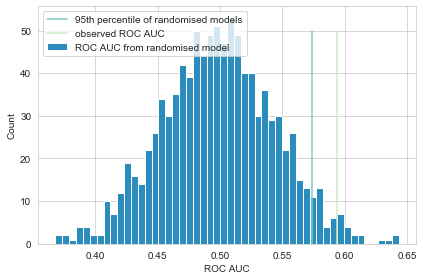

In [5]:
sns.set_palette('GnBu_r', 3)
plt.hist(aucs, bins=50)
plt.xlabel('ROC AUC')
plt.ylabel('Count')
plt.plot([0.574232,0.574232], [0, 50])
plt.plot([0.5942281312651683,0.5942281312651683], [0, 50])
plt.legend(['95th percentile of randomised models', 'observed ROC AUC', 'ROC AUC from randomised model'])
plt.tight_layout()
plt.savefig('../figures/revision/roc-auc-random.pdf')

In [353]:
aucs = pd.Series(aucs)

In [358]:
aucs.sort_values().tail(50)

350    0.574232
156    0.574681
46     0.575156
797    0.575235
936    0.575578
843    0.575947
539    0.576633
383    0.576738
429    0.577451
493    0.577662
74     0.578559
980    0.578585
190    0.580115
99     0.580695
49     0.580801
476    0.581091
655    0.581170
700    0.581513
261    0.582067
753    0.582252
208    0.582357
817    0.584731
289    0.584837
185    0.586367
647    0.587422
10     0.588477
144    0.588768
474    0.588820
848    0.590350
324    0.590799
322    0.591274
693    0.594545
480    0.594861
966    0.595125
968    0.596418
772    0.598080
422    0.598871
331    0.599293
998    0.602195
534    0.603355
849    0.603830
971    0.604252
861    0.608420
442    0.609238
820    0.611111
675    0.611164
496    0.628891
440    0.636330
104    0.640287
620    0.643479
dtype: float64